<a href="https://colab.research.google.com/github/ADVAIT135/CDAC/blob/main/6.%20Deep%20Learning/ASSIGNMENT%202/CDAC_PGDAI_DEEP_LEARNING_ASSIGNMENT__2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <u> Name :</u> ADVAIT GURUNATH CHAVAN
# <u> Email Id:</u> advaitchavan135@gmail.com
#  CDAC PGDAI DEEP LEARNING ASSIGNMENT__2

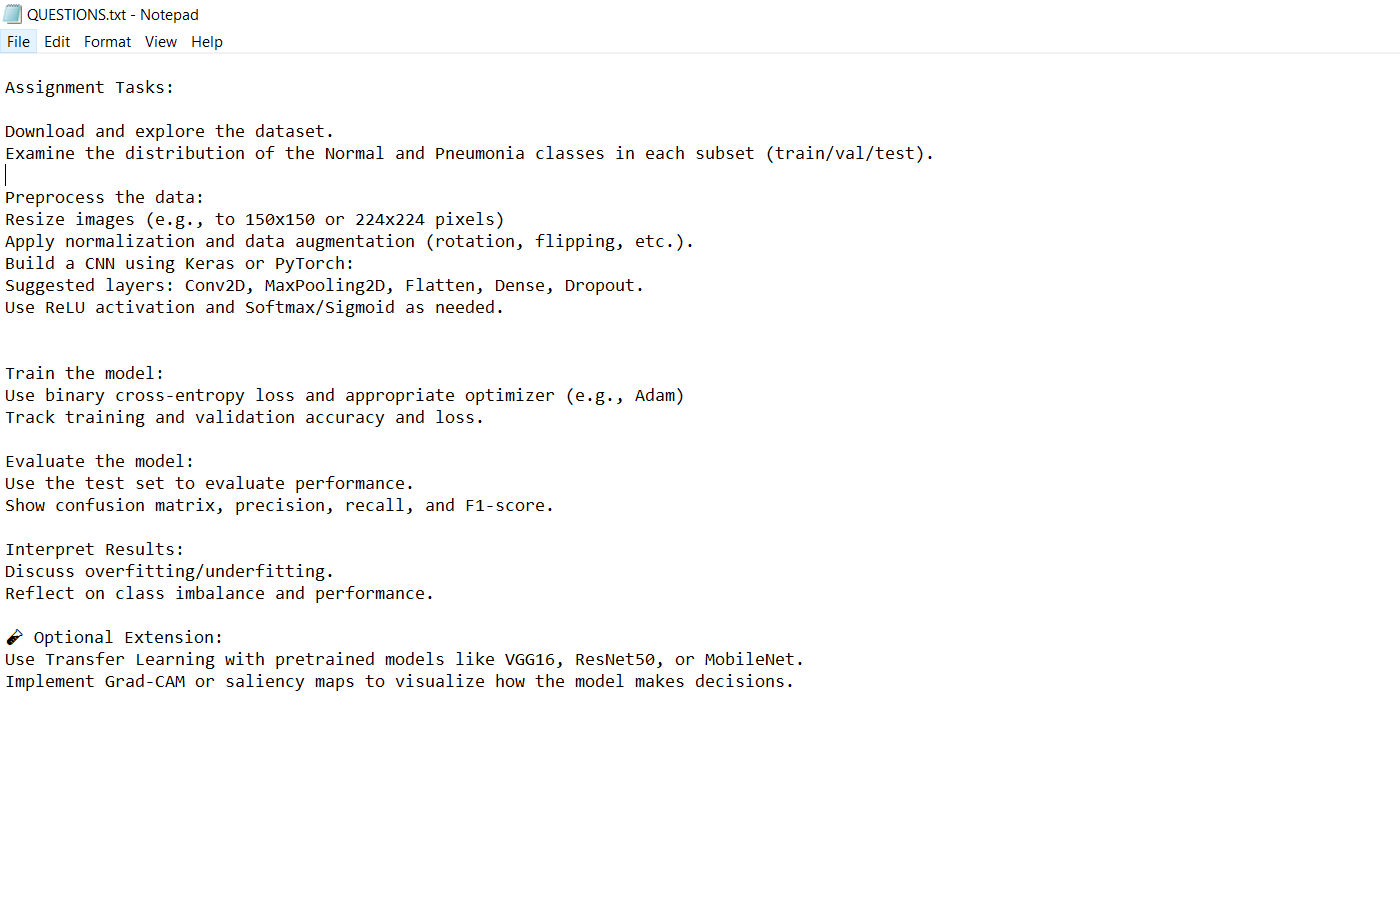

# 1. Download & Explore the Dataset

In [1]:
import os
import kagglehub

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/chest-xray-pneumonia


In [3]:
def count_images(data_path):
    counts = {}
    for subset in ['train', 'val', 'test']:
        subset_path = os.path.join(data_path, subset)
        counts[subset] = {}
        for label in os.listdir(subset_path):
            label_dir = os.path.join(subset_path, label)
            if os.path.isdir(label_dir):
                counts[subset][label] = len(os.listdir(label_dir))
    return counts

In [4]:
image_counts = count_images(r'/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray')
print("Image distribution by set and label:")
print(image_counts)

Image distribution by set and label:
{'train': {'PNEUMONIA': 3876, 'NORMAL': 1342}, 'val': {'PNEUMONIA': 9, 'NORMAL': 9}, 'test': {'PNEUMONIA': 390, 'NORMAL': 234}}


# 2. Data Preprocessing & Augmentation


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image dimensions and batch size
IMG_WIDTH, IMG_HEIGHT = 150, 150
BATCH_SIZE = 32

In [6]:
# For training: rescale and augment data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,      # randomly rotate images in the range (degrees, 0 to 180)
    shear_range=0.2,        # randomly apply shearing transformations
    zoom_range=0.2,         # randomly zoom in on images
    horizontal_flip=True,   # randomly flip images horizontally
    fill_mode='nearest'     # fill in missing pixels after a transformation
)

In [7]:
# For validation and test: only rescale
validation_datagen = ImageDataGenerator(rescale=1./255)

In [8]:
# Create generators
train_generator = train_datagen.flow_from_directory(
    os.path.join(r'/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray', 'train'),
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)
validation_generator = validation_datagen.flow_from_directory(
    os.path.join(r'/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray', 'val'),
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)
test_generator = validation_datagen.flow_from_directory(
    os.path.join(r'/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray', 'test'),
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False  # Important for evaluation so labels and predictions align
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## 3. Data Analysis: Visualizing Sample Images

In [9]:
import matplotlib.pyplot as plt
import numpy as np

In [10]:
sample_images, sample_labels = next(train_generator)

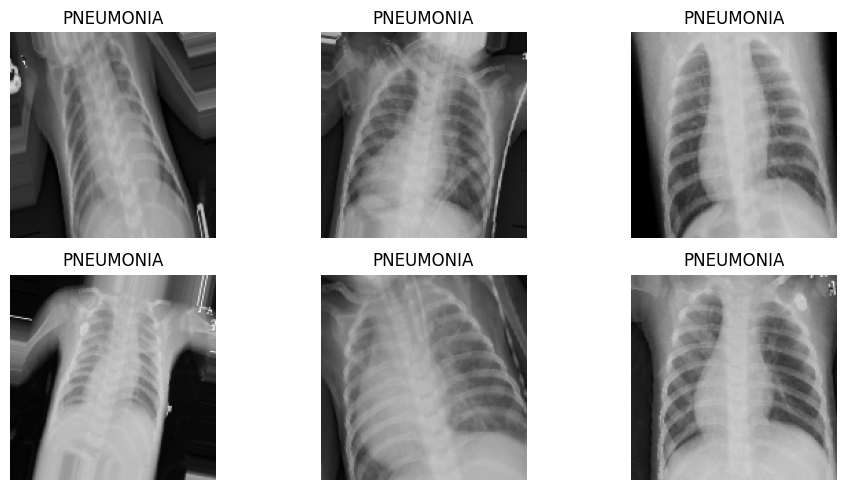

In [11]:
plt.figure(figsize=(10, 5))
for i in range(6):
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(sample_images[i])
    plt.title("PNEUMONIA" if sample_labels[i] == 1 else "NORMAL")
    plt.axis('off')
plt.tight_layout()
plt.show()

## 4. Model Development – Building, Compiling, and Training the CNN

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [13]:
model = Sequential([
    # Convolutional Block 1
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
    MaxPooling2D(2, 2),

    # Convolutional Block 2
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    # Convolutional Block 3
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    # Fully Connected Layers
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),            # Dropout for regularization
    Dense(1, activation='sigmoid')   # Sigmoid for binary classification
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

## 5. Model Training

In [15]:
EPOCHS = 20
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    epochs=EPOCHS
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 348s 2s/step - accuracy: 0.7312 - loss: 0.5765 - val_accuracy: 0.6250 - val_loss: 0.9081
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 318s 2s/step - accuracy: 0.8666 - loss: 0.2973 - val_accuracy: 0.8750 - val_loss: 0.6710
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 333s 2s/step - accuracy: 0.8921 - loss: 0.2620 - val_accuracy: 0.8125 - val_loss: 0.8208
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 322s 2s/step - accuracy: 0.9116 - loss: 0.2335 - val_accuracy: 0.6875 - val_loss: 1.1016
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 332s 2s/step - accuracy: 0.9198 - loss: 0.2203 - val_accuracy: 0.7500 - val_loss: 0.6621
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 368s 2s/step - accuracy: 0.9089 - loss: 0.2252 - val_accuracy: 0.6875 - val_loss: 1.0987
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 325s 2s/step - accuracy: 0.9173 - loss: 0.2299 - val_accuracy: 0.7500 - val_loss: 0.6194
Epoch 8/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 323s 2s/step - accuracy: 0.9278 - loss: 0.1844 - val_accu

## 6. Evaluation & Interpretation

In [16]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

In [17]:
# Generate predictions on the test set
test_generator.reset()
predictions = model.predict(test_generator, steps=test_generator.samples // BATCH_SIZE + 1)
predicted_classes = (predictions > 0.5).astype(int).flatten()

20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 739ms/step


In [18]:
true_classes = test_generator.classes

In [19]:
cm = confusion_matrix(true_classes, predicted_classes)
report = classification_report(true_classes, predicted_classes, target_names=list(test_generator.class_indices.keys()))

In [20]:
print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(report)

Confusion Matrix:
[[180  54]
 [ 10 380]]

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.95      0.77      0.85       234
   PNEUMONIA       0.88      0.97      0.92       390

    accuracy                           0.90       624
   macro avg       0.91      0.87      0.89       624
weighted avg       0.90      0.90      0.89       624



**Rows as Actual Labels, Columns as Predictions:**

The first row (actual NORMAL cases) shows that the model correctly classified 180 examples as NORMAL and misclassified 54 NORMAL cases as PNEUMONIA.

The second row (actual PNEUMONIA cases) indicates that only 10 pneumonia cases were predicted as NORMAL, while 380 were correctly identified as PNEUMONIA.

**Overfitting**



*   **Potential Sign in the Metrics:** If during training the model achieved near-perfect performance, but on the test set we see that NORMAL cases are only recalled 77% of the time, it may suggest that the model has over-specialized on features that are more distinctive to PNEUMONIA. As a result, it becomes overly cautious and misclassifies some NORMAL cases (54 false positives), favoring high recall for pneumonia.

*   **False Positives and Imbalanced Performance**: The higher false-positive rate for NORMAL (i.e., classifying a NORMAL as PNEUMONIA) could be a sign of overfitting to the pneumonia features encountered during training. Essentially, the model might have "memorized" noise or overly specific patterns seen in pneumonia cases, reducing its ability to generalize well for the NORMAL class.



**Underfitting**



*   Underfitting would be evident if both classes showed low precision, recall, and F1-scores, and the overall accuracy was significantly lower. For example, if both NORMAL and PNEUMONIA had metrics in the 60–70% range, the model would not be complex enough to handle the task.

*   The metrics for PNEUMONIA are very strong (recall 0.97, precision 0.88). This indicates that the model is capturing essential pneumonia features well and is hardly underfitting that class. However, if the training curves for NORMAL were similarly low, it would be indicative of underfitting in that portion—but the imbalance here suggests a different story.



**How Class Imbalance Affects Performance**



1.   **Training Bias:** If one class is overrepresented during training (say, pneumonia cases are more plentiful than normal), the model may bias its learning toward recognizing the dominant class. This bias can manifest in better recall for the majority class while penalizing the minority class. In our metrics, a recall of 0.97 for pneumonia indicates that nearly all pneumonia cases are detected. However, the lower recall (0.77) for NORMAL cases might suggest that the model is leaning toward labeling ambiguous cases as pneumonia, possibly because it was “exposed” to fewer examples of the NORMAL class.

2.   **Metric Misleadingness:** Overall accuracy or aggregated metrics can be deceptive in imbalanced scenarios. A 90% accuracy might look impressive, but if one class contributes disproportionately to that accuracy, it may hide suboptimal performance on the minority class. That’s why precision, recall, and especially confusion matrices are crucial—they reveal where the model might be favoring one class over another.

3.   **Clinical Relevance:** In medical diagnostics, the cost of a false negative (missing a pneumonia case) is usually much higher than that of a false positive (flagging a normal case as pneumonia). Even if the underlying data appears imbalanced, practitioners often tolerate a higher false-positive rate if it means achieving extremely high recall for a dangerous condition like pneumonia. Our example reflects this priority by achieving a very high recall for pneumonia (0.97), even though it comes at the cost of misclassifying some NORMAL cases.



